In [1]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np
import imghdr
from tensorflow.keras import models, layers
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=25

In [3]:
trainingdataset=tf.keras.preprocessing.image_dataset_from_directory('Training Dataset',
seed=123,
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


In [4]:
class_names = trainingdataset.class_names
class_names

['Pepper_bell_Bacterial_spot', 'Pepper_bell_healthy']

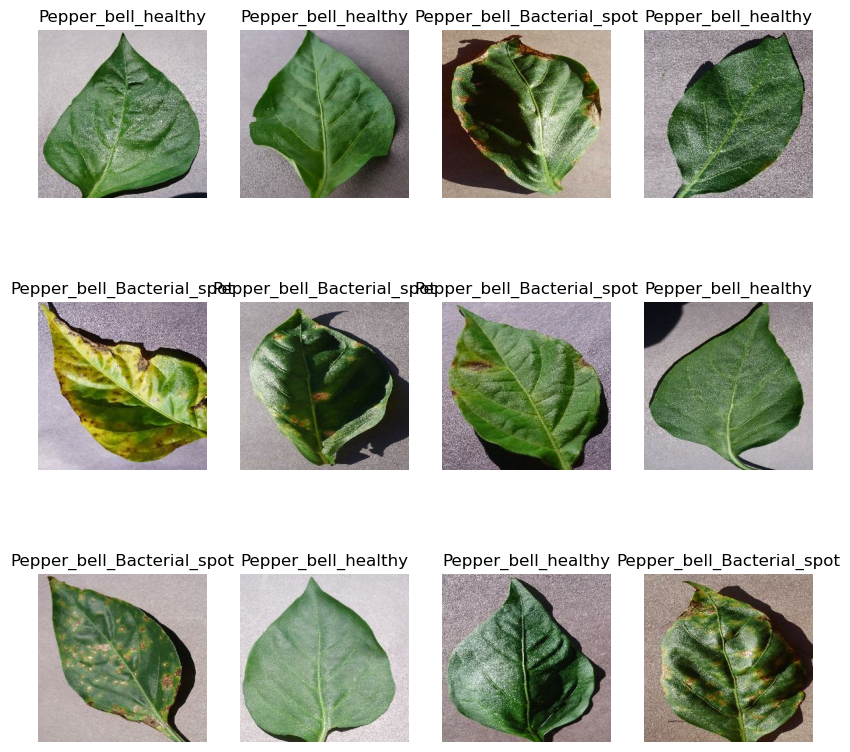

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in trainingdataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
len(trainingdataset)

78

In [7]:
train_size = 0.8
len(trainingdataset)*train_size

62.400000000000006

In [8]:
train_ds = trainingdataset.take(62)
len(train_ds)

62

In [9]:
test_ds = trainingdataset.skip(64)
len(test_ds)

14

In [10]:
val_size=0.1
len(trainingdataset)*val_size

7.800000000000001

In [11]:
val_ds = trainingdataset.take(7)
len(val_ds)

7

In [12]:
len(train_ds)

62

In [13]:
len(test_ds)

14

In [14]:
len(val_ds)

7

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(trainingdataset)

In [17]:
len(train_ds)

62

In [18]:
len(val_ds)

7

In [19]:
len(test_ds)

9

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [70]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [71]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
62/62 [==============================] - 72s 1s/step - loss: 0.6686 - accuracy: 0.6179 - val_loss: 0.5476 - val_accuracy: 0.7277
Epoch 2/25
62/62 [==============================] - 69s 1s/step - loss: 0.3185 - accuracy: 0.8762 - val_loss: 1.1916 - val_accuracy: 0.7098
Epoch 3/25
62/62 [==============================] - 69s 1s/step - loss: 0.1853 - accuracy: 0.9368 - val_loss: 0.2215 - val_accuracy: 0.9152
Epoch 4/25
62/62 [==============================] - 69s 1s/step - loss: 0.0683 - accuracy: 0.9806 - val_loss: 0.1143 - val_accuracy: 0.9777
Epoch 5/25
62/62 [==============================] - 69s 1s/step - loss: 0.0332 - accuracy: 0.9862 - val_loss: 0.0533 - val_accuracy: 0.9777
Epoch 6/25
62/62 [==============================] - 71s 1s/step - loss: 0.0460 - accuracy: 0.9898 - val_loss: 0.0607 - val_accuracy: 0.9911
Epoch 7/25
62/62 [==============================] - 70s 1s/step - loss: 0.0631 - accuracy: 0.9796 - val_loss: 0.0778 - val_accuracy: 0.9777
Epoch 8/25
62/62 [==

In [72]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [73]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [76]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 2s 169ms/step - loss: 3.7601e-04 - accuracy: 1.0000


In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

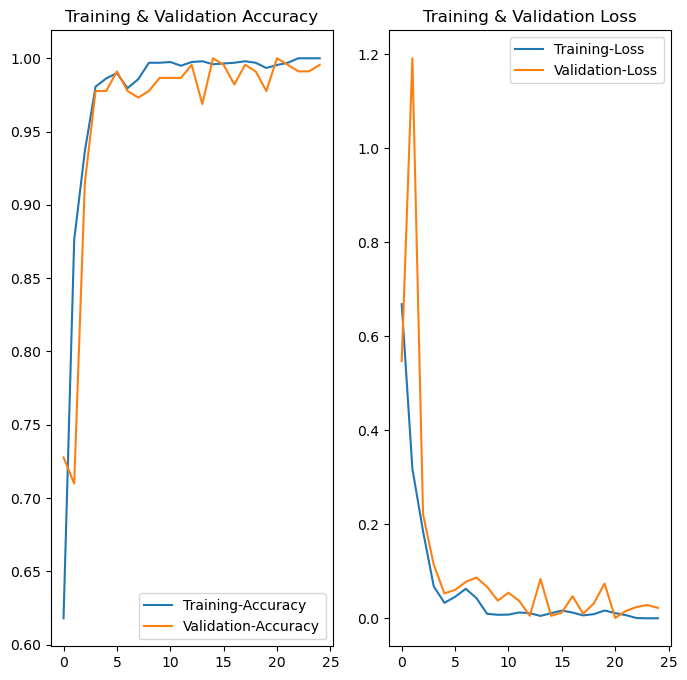

In [85]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training-Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation-Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training-Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation-Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')
plt.show()

first image to predict
actual label: Pepper_bell_Bacterial_spot
1/1 [==============================] - 0s 200ms/step
predicted label: Pepper_bell_Bacterial_spot


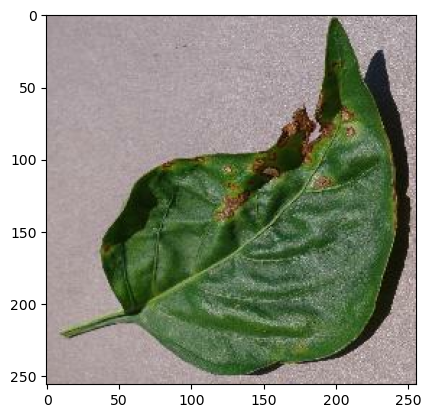

In [43]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])